# Optional Lab - Simple Neural Network
In this lab we will build a small neural network using Tensorflow.
   <center> <img  src="./images/C2_W1_CoffeeRoasting.png" width="400" />   <center/>


In [43]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle') #It applies a custom plotting style from a local file (deeplearning.mplstyle) for consistent visual aesthetics (colors, fonts, grid, etc.).
import tensorflow as tf
#Imports specific Keras classes:
from tensorflow.keras.models import Sequential  # type: ignore #A linear stack of layers—ideal for feedforward neural networks. A feedforward neural network (FNN) is the simplest type of artificial neural network. It's called "feedforward" because the flow of data is one-way: from input to output, without loops or cycles.
from tensorflow.keras.layers import Dense # type: ignore #A fully connected layer (used frequently in neural nets).
from lab_utils_common import dlc 
'''
This line imports dlc from a custom Python module called lab_utils_common.
dlc is likely a helper class or object that provides visualization or utility functions used in the deep learning labs.
You might use it to draw neurons, connections, or data flows in the network.
'''
from lab_coffee_utils import load_coffee_data, plt_roast, plt_prob, plt_layer, plt_network, plt_output_unit
'''
This imports several custom functions from another lab-specific module called lab_coffee_utils.
Each function serves a specific purpose related to the coffee roasting classification dataset:
    load_coffee_data: Loads the dataset (probably returns input X and output Y values for training/testing).
    plt_roast: Likely plots the data points (e.g., time vs. temperature) to visualize roasting outcomes.
    plt_prob: Probably visualizes predicted probabilities or decision boundaries.
    plt_layer: Helps visualize the internal computations or outputs of a specific neural network layer.
    plt_network: Visualizes the full neural network structure (layers, weights, activations).
    plt_output_unit: Focuses on visualizing the behavior of the final output unit.

These are meant to make neural network operations visible and intuitive, especially for educational purposes.
'''
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) 
tf.autograph.set_verbosity(0)


In [44]:
'''
import logging:
    This imports Python’s built-in logging module, which is used to control what messages get shown in your console or notebook (info, warnings, errors, etc.).

logging.getLogger("tensorflow").setLevel(logging.ERROR):
    This line suppresses TensorFlow’s verbose output, which can include a lot of unnecessary info or warnings.
    It tells the TensorFlow logger to only show error messages, and ignore all "info" or "warning" logs.
    Makes your output cleaner and easier to follow.

tf.autograph.set_verbosity(0):
    This turns off AutoGraph debug output.
    AutoGraph is a TensorFlow feature that converts Python functions into TensorFlow graph code under the hood.
By setting verbosity to 0, you're telling TensorFlow: “don’t print extra debug info from AutoGraph.”
''';

## DataSet

In [45]:
X,Y = load_coffee_data();
print(X.shape, Y.shape)

(200, 2) (200, 1)


Let's plot the coffee roasting data below. The two features are Temperature in Celsius and Duration in minutes. [Coffee Roasting at Home](https://www.merchantsofgreencoffee.com/how-to-roast-green-coffee-in-your-oven/) suggests that the duration is best kept between 12 and 15 minutes while the temp should be between 175 and 260 degrees Celsius. Of course, as temperature rises, the duration should shrink. 

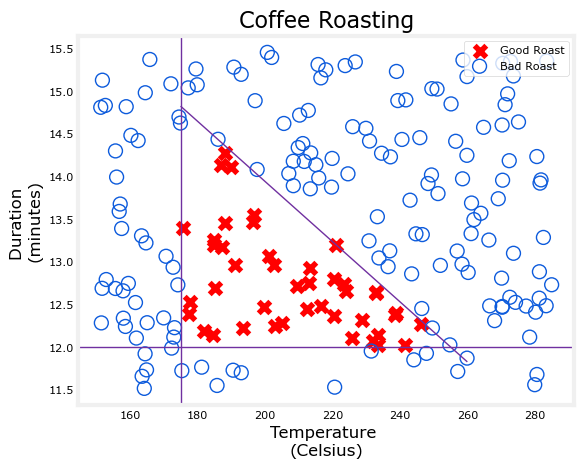

In [46]:
plt_roast(X,Y)

### Normalize Data
Fitting the weights to the data (back-propagation, covered in next week's lectures) will proceed more quickly if the data is normalized. This is the same procedure you used in Course 1 where features in the data are each normalized to have a similar range. 
The procedure below uses a Keras [normalization layer](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/). It has the following steps:
- create a "Normalization Layer". Note, as applied here, this is not a layer in your model.
- 'adapt' the data. This learns the mean and variance of the data set and saves the values internally.
- normalize the data.  
It is important to apply normalization to any future data that utilizes the learned model.

In [47]:
'''
Normalization class
keras.layers.Normalization(axis=-1, mean=None, variance=None, invert=False, **kwargs)
A preprocessing layer that normalizes continuous features.
This layer will shift and scale inputs into a distribution centered around 0 with standard deviation 1. 
It accomplishes this by precomputing the mean and variance of the data, and calling (input - mean) / sqrt(var) at runtime.
''';

In [48]:
X
type(X)

numpy.ndarray

In [49]:
print(f"Temperature Max, Min pre normalization: {np.max(X[:,0]):0.2f}, {np.min(X[:,0]):0.2f}")
print(f"Duration    Max, Min pre normalization: {np.max(X[:,1]):0.2f}, {np.min(X[:,1]):0.2f}")
norm_l = tf.keras.layers.Normalization(axis=-1)
'''
This creates a Normalization layer in Keras.
The parameter axis=-1 tells the layer to normalize across the last axis, which is typical when your input is a matrix where each row is a sample and each column is a feature.
This layer will learn the mean and variance of the input data and later use them to normalize new inputs.
'''
norm_l.adapt(X)  # learns mean, variance
'''
This line "adapts" the layer to your dataset X.
It computes and stores the mean and variance of the dataset X internally.
X should be a NumPy array or Tensor containing your training data.
👉 Think of this as the training step for the normalization layer.
'''
Xn = norm_l(X)
'''
Now you're applying the learned (trained) normalization layer to the input X.
The result, Xn, is the normalized version of X, where:
Each feature (column) will have mean ≈ 0 and standard deviation ≈ 1.
'''
print(f"Temperature Max, Min post normalization: {np.max(Xn[:,0]):0.2f}, {np.min(Xn[:,0]):0.2f}")
print(f"Duration    Max, Min post normalization: {np.max(Xn[:,1]):0.2f}, {np.min(Xn[:,1]):0.2f}")

Temperature Max, Min pre normalization: 284.99, 151.32
Duration    Max, Min pre normalization: 15.45, 11.51
Temperature Max, Min post normalization: 1.66, -1.69
Duration    Max, Min post normalization: 1.79, -1.70


Tile/copy our data to increase the training set size and reduce the number of training epochs.

In [50]:
#This code is artificially increasing the size of your training dataset by tiling (repeating) the same data multiple times.
Xt = np.tile(Xn,(1000,1)) #Repeats the data 1000 times along the rows (axis 0), Does not repeat along the columns (axis 1).
Yt= np.tile(Y,(1000,1))   
print(Xt.shape, Yt.shape)   
# ❓ Why do this?
    # This is not true data augmentation—you're just repeating the same samples.
    # But it helps if you:
    # Have a very small dataset,
    # Need to simulate training over more iterations or larger batch sizes,
    # Want to avoid training on just a few samples per epoch, which can make training unstable.

(200000, 2) (200000, 1)


## Tensorflow Model

### Model
   <center> <img  src="./images/C2_W1_RoastingNetwork.PNG" width="200" />   <center/>  
Let's build the "Coffee Roasting Network" described in lecture. There are two layers with sigmoid activations as shown below:

In [51]:
tf.random.set_seed(1234)  # applied to achieve consistent results
model = Sequential(
    [
        tf.keras.Input(shape=(2,)),
        Dense(3, activation='sigmoid', name = 'layer1'),
        Dense(1, activation='sigmoid', name = 'layer2')
     ]
)
'''
1) Sequential([...])
    This tells TensorFlow to build a neural network by stacking layers in order.
    Each layer's output becomes the next layer's input.

2) tf.keras.Input(shape=(2,))
Specifies the input shape: each training example has 2 features (temperature and duration).
It allows TensorFlow to initialize the model’s weight and bias parameters before actual data is passed.
If you don’t include an Input layer, TensorFlow will infer the input shape automatically the first time you call model.fit(...) or model.predict(...).
So it’s optional, but helpful in exploratory work and when building more complex architectures.

3) Dense(3, activation='sigmoid', name='layer1')
A fully connected layer (Dense) with 3 neurons.
Each neuron uses the sigmoid activation function.
Named "layer1" for reference (useful for visualization, debugging, or access by name).

4) Dense(1, activation='sigmoid', name='layer2')
Another Dense layer, this time with 1 neuron.
Also uses sigmoid activation, likely to produce a value between 0 and 1 (e.g., for binary classification).
Named "layer2".
Including the sigmoid activation in the final layer is not considered best practice...
Why?
Because for binary classification tasks, using sigmoid in the final layer plus a binary_crossentropy loss function can lead to numerical instability (especially during backpropagation when activations are very close to 0 or 1).
Better practice:
    Use a linear output (no activation) in the final layer.
    Let the loss function internally apply sigmoid (e.g., by using from_logits=True in the loss definition).
    ✅ This avoids extremely small gradients and improves stability during training.

✅ What does from_logits=True mean?
When using a loss function like binary_crossentropy or categorical_crossentropy, the argument from_logits=True tells TensorFlow:
“The output of my model is not passed through an activation function like sigmoid or softmax — it’s a raw score (called a logit). Please apply the appropriate activation function internally.”

🔍 What are logits?
A logit is just a raw output from the last neuron in the network, before any activation like sigmoid or softmax.
For binary classification: a logit could be any real number like -3.1, 0.0, or 2.8.
After applying sigmoid, it becomes a probability between 0 and 1.
''';

>**Note 1:** The `tf.keras.Input(shape=(2,)),` specifies the expected shape of the input. This allows Tensorflow to size the weights and bias parameters at this point.  This is useful when exploring Tensorflow models. This statement can be omitted in practice and Tensorflow will size the network parameters when the input data is specified in the `model.fit` statement.  
>**Note 2:** Including the sigmoid activation in the final layer is not considered best practice. It would instead be accounted for in the loss which improves numerical stability. This will be described in more detail in a later lab. So don’t always apply sigmoid manually at the end — let the loss handle it when appropriate.


In [52]:
#To find out what class model_1 is an instance of, you can use Python’s built-in type() function:
print(type(model))
# 🔍 Explanation:
# model is an instance of the class:            tf.keras.models.Sequential
# This class is a subclass of tf.keras.Model, which in turn inherits from Layer. It’s used to stack layers linearly, where each layer’s output is passed as the input to the next.

# TensorFlow does not instantiate the weights and biases at the moment you run:
# model_1 = Sequential([...])
# Instead, it defines the architecture, but delays the creation of weights and biases until the model sees data for the first time.

<class 'keras.src.models.sequential.Sequential'>


<details>
  <summary><b style="color:red;">binary_crossentropy</b></summary>

🧠 **What is a loss function?**  
A loss function measures **how far off the model’s predictions are from the actual (true) values**.  
It acts like a guide — during training, the model adjusts its weights to minimize this loss, improving its accuracy.

Think of it as:  

🔍 *“How wrong is the model right now?”*  

**Lower loss = better predictions.**


🔢 **What is `binary_crossentropy`?**  
`binary_crossentropy` is a loss function used for binary classification tasks — where the output is either 0 or 1.

You use it when:  
- You have one output neuron with a sigmoid activation (which outputs a value between 0 and 1),  
- You're solving a yes/no, true/false, or class A/class B problem.

📘 **How it works:**  
For each training example, it compares:  
- The model’s predicted probability: ŷ (a number between 0 and 1),  
- The actual label: y (either 0 or 1).

The formula:  
```python
binary_crossentropy = - [ y * log(ŷ) + (1 - y) * log(1 - ŷ) ]
```

- If $y = 1$, the second term disappears, and it becomes $-\log(\hat{y})$ 
- If $y = 0$, the first term disappears, and it becomes $-\log(1 - \hat{y})$

So the loss is small when the predicted probability matches the true label (e.g., ŷ = 0.98 when y = 1),  
and large when the model is confident and wrong (e.g., ŷ = 0.01 when y = 1).


✅ **Why it's used:**  
- It penalizes confident wrong predictions more heavily than uncertain ones.  
- It’s smooth and differentiable, which makes it perfect for optimization via gradient descent.  
- It works well with the sigmoid activation function in the final layer.


📊 **Intuition:**  
- If the true label is 1, you want the model to output a probability close to 1.  
- If the true label is 0, you want the model to output a probability close to 0.  
- `binary_crossentropy` pushes the model in that direction.

</details>

The `model.summary()` provides a description of the network:

In [53]:
# The output of model.summary() is showing you a summary of your neural network's architecture.
model.summary()
'''
Model: "sequential_2"
    This is the name TensorFlow automatically gave your model (sequential_2). You can customize this if you'd like.

🧱 Layer Details
You have two layers:
1. layer1 (Dense)
Output Shape: (None, 3)
Param #: 9
Type: Dense (fully connected)
Output shape: Each input will be transformed into a 3-dimensional vector (3 neurons).
None means batch size is flexible.
Params: 9 trainable parameters:
You had 2 input features.
    So: (2 weights per neuron × 3 neurons) + 3 biases = (2×3) + 3 = 9

2. layer2 (Dense)
Output Shape: (None, 1)
Param #: 4
Type: Dense (fully connected)
Output shape: Each sample outputs a single number (for binary classification).
Params: 4 trainable parameters:
3 inputs from previous layer × 1 neuron + 1 bias = 3 + 1 = 4

🧮 Total Parameters
Total params: 13
Trainable params: 13
Non-trainable params: 0
You have 13 total parameters (weights + biases across all layers).
All of them are trainable, meaning TensorFlow will update them during training.
No frozen (non-trainable) layers yet.

Batch size refers to the number of training examples the model sees at once before updating its internal parameters (weights).
🧮 Example:
Let’s say your training set has 1000 samples and you choose:
batch_size = 100
Then:
The model will see 100 samples at a time
It will take 10 batches to complete 1 epoch

after 1 epoch ends, another epoch begins, if you’ve specified more than one in model.fit(...).
🔁 What happens after 1 epoch:
The model has seen all training samples once, divided into batches.
It has updated its weights 10 times (if batch size is 100 and you have 1000 samples).
The loss is usually lower than it was at the beginning (if training is going well).
Then, epoch 2 starts:
The data is often shuffled again (default in Keras).
The model goes through all samples again, updating weights per batch, just like in epoch 1.
This process continues for as many epochs as you’ve specified.
'''

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer1 (Dense)                  │ (None, 3)              │             9 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 1)              │             4 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13 (52.00 B)

 Trainable params: 13 (52.00 B)

 Non-trainable params: 0 (0.00 B)

'\nModel: "sequential_2"\n    This is the name TensorFlow automatically gave your model (sequential_2). You can customize this if you\'d like.\n\n🧱 Layer Details\nYou have two layers:\n1. layer1 (Dense)\nOutput Shape: (None, 3)\nParam #: 9\nType: Dense (fully connected)\nOutput shape: Each input will be transformed into a 3-dimensional vector (3 neurons).\nNone means batch size is flexible.\nParams: 9 trainable parameters:\nYou had 2 input features.\n    So: (2 weights per neuron × 3 neurons) + 3 biases = (2×3) + 3 = 9\n\n2. layer2 (Dense)\nOutput Shape: (None, 1)\nParam #: 4\nType: Dense (fully connected)\nOutput shape: Each sample outputs a single number (for binary classification).\nParams: 4 trainable parameters:\n3 inputs from previous layer × 1 neuron + 1 bias = 3 + 1 = 4\n\n🧮 Total Parameters\nTotal params: 13\nTrainable params: 13\nNon-trainable params: 0\nYou have 13 total parameters (weights + biases across all layers).\nAll of them are trainable, meaning TensorFlow will upda

Your model looks like this:

```python
Input (2 features)
   ↓
Dense layer (3 neurons, sigmoid) → 9 parameters
   ↓
Dense layer (1 neuron, sigmoid) → 4 parameters
   ↓
Output (prediction)
```

The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [54]:
L1_num_params = 2 * 3 + 3   # W1 parameters  + b1 parameters
L2_num_params = 3 * 1 + 1   # W2 parameters  + b2 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params  )

L1 params =  9 , L2 params =  4


Let's examine the weights and biases that TensorFlow has instantiated (after running `model.summary()`). The weight matrix $W$ should have a shape of (number of input features, number of units in the layer), while the bias vector $b$ should match the number of units in the layer:

- In the first layer with 3 units, we expect $W$ to have a shape of (2, 3), and $b$ to have 3 elements. **Each column of $W$ contains the weights for one unit (neuron) in the layer**.

- In the second layer with 1 unit, we expect $W$ to have a shape of (3, 1), and $b$ to have 1 element.

<details>
  <summary><b style="color:red;">more information</b></summary>

✅ **In mathematical notation:**

We often write the linear part of a neural network layer as:
$$
z = W^\top a + b
$$

Where:
- $a$: input vector (shape: $n \times 1$)
- $W^\top$: weight matrix transposed (shape: $m \times n$)
- $b$: bias vector (shape: $m \times 1$)
- $z$: pre-activation output (shape: $m \times 1$)

So, **each unit (neuron)** computes a dot product between its weight vector (a column of $W$) and the input $a$.

✅ **In TensorFlow/Keras implementation, it’s the other way:**

The implementation does:
$$
z = a \cdot W + b
$$

Where:
- $a$: input row vector (shape: $1 \times n$ or $m \times n$ for a batch)
- $W$: weight matrix (shape: $n \times h$, where $h$ is number of units)
- Output $z$: shape $m \times h$

So in code:
- The weight matrix is **not transposed**.
- The input is on the **left** of the multiplication.


🔁 **Summary**

| Context              | Formula                 | Interpretation                  |
|----------------------|------------------------|----------------------------------|
| Math notation        | $W^\top a + b$         | Weights as **columns**          |
| TensorFlow code      | $a \cdot W + b$        | Inputs as **rows**, weights as columns |

</details>

In [55]:
#the weights and biases that TensorFlow has instantiated (initialized) immediately after running model.summary(), before starting training:
W1, b1 = model.get_layer("layer1").get_weights()
'''
We'll get:
    W1: a NumPy array of shape (2, 3) — the weight matrix connecting 2 input features to 3 neurons.
    b1: a NumPy array of shape (3,) — the bias values for the 3 neurons.
'''
W2, b2 = model.get_layer("layer2").get_weights()
'''
W2: shape (3, 1) — weights from 3 neurons in layer1 to 1 neuron in layer2.
b2: shape (1,) — bias for the single output neuron.
'''
'''
🎲 Important:
These weights and biases are randomly initialized, not learned.
They were created when you ran model.summary() (or more precisely, when the model was first built with a known input shape).

🔁 Summary:
get_weights() fetches the raw, randomly initialized weights and biases.
You haven’t started training yet — these are just the starting point before learning begins.
'''
print(f"W1{W1.shape}:\n", W1, f"\n\nb1{b1.shape}:", b1,'\n')
print(f"W2{W2.shape}:\n", W2, f"\n\nb2{b2.shape}:", b2)

# When you call model.summary() after defining an explicit input shape (via tf.keras.Input(...)in Sequential(...)), TensorFlow builds the model, which means:
# It instantiates the weights and biases (allocates and initializes them),
# Even though you haven’t trained the model yet.

W1(2, 3):
 [[-0.63  0.39  0.34]
 [-0.92 -0.65  0.4 ]] 

b1(3,): [0. 0. 0.] 

W2(3, 1):
 [[-1.02]
 [-1.17]
 [-0.67]] 

b2(1,): [0.]


<details>
  <summary><b style="color:red;">hitherto</b></summary>

1. **We defined the model:**  

  ```python
  model = Sequential([...])
  ```
  This sets up the architecture, but does not instantiate weights and biases yet.

2. **Then we ran:**  

  ```python
  model.summary()
  ```
  This **does trigger model building** if the input shape is specified (which we did via `tf.keras.Input(shape=(2,))` in the previous step).

  ✅ So at this point:
  - The model is built. 
  - The layers now have weights and biases instantiated.

  We’ll see output shapes and parameter counts in the summary.  

3. **We accessed weights:**
  ```python
  W1, b1 = model.get_layer("layer1").get_weights()
  W2, b2 = model.get_layer("layer2").get_weights()
  ```
  ✅ These will work without error, because **the model has already been built by the time model.summary() ran**.

---
✅ **Why I used "instantiate" here:**

The verb “instantiate” comes from object-oriented programming (OOP), where it means:  
*“To create a concrete instance of something based on a definition or blueprint.”*

🔍 **In this context (TensorFlow/Keras):**  
When you define a layer like `Dense(3)`, you're saying:  
*“I want a layer with 3 units,”*  
but no actual weights or biases exist yet — it’s just a blueprint.

When the model is built (e.g., after `model.summary()` or `model.fit(...)`), TensorFlow:  
- Creates actual tensors for weights and biases,  
- Allocates memory,  
- Initializes values (typically using **random initialization**).

That’s the moment the layer’s weights and biases are **instantiated** — turned from an abstract specification into real, usable objects.  
They’re randomly initialized using specific strategies designed to help the neural network train efficiently.

🔍 **Why use random initialization?**  
If all weights were initialized to 0:  
- Every neuron in a layer would learn the same thing (no diversity).  
- The model would fail to learn useful representations.

So random initialization helps:  
- Break symmetry between neurons,  
- Ensure diverse gradient flows during backpropagation,  
- Kick-start learning.

</details>

### Now we move from **model definition** to **training**. 

The following statements will be described in detail in Week2. For now:
- The `model.compile` statement defines a loss function and specifies a compile optimization.
- The `model.fit` statement runs gradient descent and fits the weights to the data.

In [56]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
)
'''
We're telling TensorFlow how to train the model:
    Loss function: BinaryCrossentropy()
        Used for binary classification.
        Compares predicted probabilities (from the sigmoid in our output layer) with the true labels (0 or 1).

    Optimizer: Adam with learning_rate=0.01
        This controls how the weights get updated during training.
        Adam (Adaptive Moment Estimation) is a popular and adaptive optimization algorithm.

❓What if we get stuck in a local minimum?
In theory, yes, optimizers can get stuck in:
A local minimum
A saddle point (where the gradient is near zero but it’s not a minimum)
Or a flat region (plateau)

But in practice, especially with modern optimizers like Adam, it's less likely to be a major problem.
In practice:
Neural networks often don't have bad local minima, especially in high-dimensional spaces — many “local minima” are good enough.
It's saddle points and plateaus that cause more trouble, and optimizers like Adam are designed to handle those better than older methods.

'''


model.fit(
    Xt,Yt,            
    epochs=10,
)
'''
We start the training process:
    Xt: input training data (after tiling/repetition)
    Yt: corresponding target labels
    epochs=10: the model will see the entire dataset 10 times

🔁 What happens during training:
    For each epoch:
        The model splits Xt into batches (default batch size is 32).
    For each batch:
        It performs a forward pass (predicts outputs).
        Computes the loss (how wrong it was).
        Performs a backward pass (gradient computation).
        Updates the weights and biases using the Adam optimizer.
    After all batches are done, that’s one epoch.
    The process repeats for the next epoch.

🔍 Behind the scenes:
The weights W1, W2 and biases b1, b2 are updated after every batch.
The loss should decrease over time, assuming the model is learning.
If we print model.get_weights() now, we'll see different values from what we saw before training — the model has learned.
''';

Epoch 1/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 296us/step - loss: 0.2446
Epoch 2/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 300us/step - loss: 0.0867
Epoch 3/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 285us/step - loss: 0.0216
Epoch 4/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 260us/step - loss: 0.0129
Epoch 5/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step - loss: 0.0088
Epoch 6/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 261us/step - loss: 0.0062
Epoch 7/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 256us/step - loss: 0.0044
Epoch 8/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step - loss: 0.0032
Epoch 9/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step - loss: 0.0023
Epoch 10/10
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 2s 259us/step - loss: 0.0017


#### Epochs and batches
In the `fit` statement above, the number of epochs was set to 10. This means the entire dataset will be used to train the model 10 times.

During training, you’ll see output that looks like this:
```python
Epoch 1/10
6250/6250 [==============================] - 6s 910us/step - loss: 0.1782
```
- The first line, Epoch 1/10, indicates that the model is running the first of 10 training cycles.
- For efficiency, TensorFlow breaks the dataset into batches. The default batch size is 32.
- If the dataset has 200,000 examples, that results in 6250 batches per epoch (200,000 ÷ 32).
- The second line, 6250/6250, shows the progress of batch processing during the epoch — in this case, all batches have been completed.

#### Updated Weights
After fitting, the weights have been updated (the model has learned): 

In [57]:
# If we print model.get_weights() now, we'll see different values from what we saw before training — the model has learned.
W1, b1 = model.get_layer("layer1").get_weights()
W2, b2 = model.get_layer("layer2").get_weights()
print(f"W1{W1.shape}:\n", W1, f"\n\nb1{b1.shape}:", b1,'\n')
print(f"W2{W2.shape}:\n", W2, f"\n\nb2{b2.shape}:", b2)

W1(2, 3):
 [[-11.25  -0.14  14.39]
 [ -0.22  -9.05  12.02]] 

b1(3,): [-12.28 -11.28   1.85] 

W2(3, 1):
 [[-53.09]
 [-48.83]
 [-45.08]] 

b2(1,): [27.99]


You can see that the values are different from those we printed before calling `model.fit(...)`. With these updated weights, the model should now be able to distinguish between a good and bad coffee roast.

For the purpose of the next section, instead of using the weights you just trained, we’ll load a set of pre-saved weights from a previous training run. This ensures that the notebook remains robust to changes in TensorFlow over time. Since training can yield slightly different results each time, the following discussion assumes that the model has the specific weights we’re about to load.

Feel free to re-run the notebook later with the cell below commented out to see if the results change. If your training earlier achieved a low loss (e.g., 0.002), you’ll likely observe similar results.

In [58]:
# W1 = np.array([
#     [-8.94,  0.29, 12.89],
#     [-0.17, -7.34, 10.79]] )
# b1 = np.array([-9.87, -9.28,  1.01])
# W2 = np.array([
#     [-31.38],
#     [-27.86],
#     [-32.79]])
# b2 = np.array([15.54])
# model.get_layer("layer1").set_weights([W1,b1])
# model.get_layer("layer2").set_weights([W2,b2])
# print(f"W1{W1.shape}:\n", W1, f"\n\nb1{b1.shape}:", b1,'\n')
# print(f"W2{W2.shape}:\n", W2, f"\n\nb2{b2.shape}:", b2)

<details>
  <summary><b style="color:red;">Training vs. Inference in Machine Learning</b></summary>

**Training Phase**

**Goal:** Learn from data by adjusting weights and biases.

You run:
```python
model.fit(X_train, y_train, epochs=...)
```
- The model uses **forward and backward passes** to minimize the loss function.

**Inference Phase**

**Goal:** Use the trained model to make predictions on new/unseen data.

You run:
```python
y_pred = model.predict(X_new)
```
- The model does a **forward pass only** — no weight updates.

**So:**  

  Once the model is **trained** (i.e., has learned), you use it for **inference**.

This is when it can:

- **Classify new coffee roasts**
- **Predict outcomes**
- **Make real-world decisions**
</details>

### **Once the model is trained (i.e., has learned), we use it for inference—that is, making predictions on new data**

### Predictions
<img align="left" src="./images/C2_W1_RoastingDecision.PNG"     style=" width:380px; padding: 10px 20px; " >

Once you have a trained model, you can use it to make predictions. Recall that the model's output is a probability—in this case, the probability that a roast is good. To make a decision based on this probability, you need to apply a threshold. Here, we will use a threshold of 0.5: if the predicted probability is greater than or equal to 0.5, we classify it as a good roast; otherwise, it's classified as a bad roast.

Let’s start by creating some new input data. The model expects one or more examples, with each example represented as a row in a matrix. Since we have two features, the input matrix should have the shape (m, 2), where m is the number of examples.

#### **Remember, we normalized the input features during training, so we must normalize our test data in the same way. To make a prediction, we use the model’s `predict` method.**

In [59]:
X_test = np.array([
    [200,13.9],  # postive example
    [200,17]])   # negative example
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
print("predictions = \n", predictions)
# len(predictions)    #2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
predictions = 
 [[9.81e-01]
 [3.68e-08]]


<details>
  <summary><b style="color:red;">a question</b></summary>

**Question:**  

In the code above, I use a normalization layer `norm_l` that I previously built and adapted to my training data using `norm_l.adapt(X_train)`. Now I want to apply this layer to my test data. Is it correct to simply do:
```python
X_testn = norm_l(X_test)
```
Or should I first call `norm_l.adapt(X_test)` before normalizing the test set?

**Answer:**

✅ **No, you should not call `norm_l.adapt(X_test)` again.**  
That would be incorrect.  

📌 **Why?**

The **Normalization** layer in TensorFlow acts as a preprocessing step that learns the *mean and variance* of your **training set** during:
```python
norm_l.adapt(X_train)
```
- After this, it holds those training-set statistics internally.

So when you later apply:
```python
X_testn = norm_l(X_test)
```
…it uses the **training mean and variance** to normalize your test data. ✅

This is exactly what you want during inference, because:
- You want the test data to be **scaled in the same way** as the training data.
- You do **not** want to "peek" at the test data distribution—doing so would cause **data leakage**.

❌ **Why not do `norm_l.adapt(X_test)`?**
Because that would:
- Recompute the mean and variance using the **test set**—which changes the normalization logic.
- Introduce bias and destroy the generalization validity of your model.
- Be a form of **data leakage**.

✅ **So yes, your current code is correct:**
```python
X_testn = norm_l(X_test)
predictions = model.predict(X_testn)
```

You're using the normalization layer that was **trained (adapted) on X_train**—perfect!
</details>

To convert the probabilities to a decision, we apply a threshold:

In [60]:
# np.zeros_like(predictions).shape    #(2, 1)
np.zeros_like(predictions)

array([[0.],
       [0.]], dtype=float32)

In [61]:
yhat = np.zeros_like(predictions)
for i in range(len(predictions)): #len() returns the size of the first dimension of the array — which typically corresponds to the number of rows (i.e., number of prediction examples).
    if predictions[i] >= 0.5:
        yhat[i] = 1
    else:
        yhat[i] = 0
print(f"decisions = \n{yhat}")

decisions = 
[[1.]
 [0.]]


This can be accomplished more succinctly:

In [62]:
yhat = (predictions >= 0.5).astype(int)
print(f"decisions = \n{yhat}")

decisions = 
[[1]
 [0]]


## Layer Functions
Let’s explore the behavior of the individual units (neurons) in the first layer to understand their role in the coffee roasting decision. We'll visualize the output of each unit across a range of input values (duration and temperature). Each unit applies a logistic (sigmoid) activation function, producing outputs between 0 and 1. The shading in each plot indicates the activation level of the unit for different input combinations.

> Note: In the lab exercises, units and layers are typically numbered starting from 0, whereas lectures may use 1-based indexing.

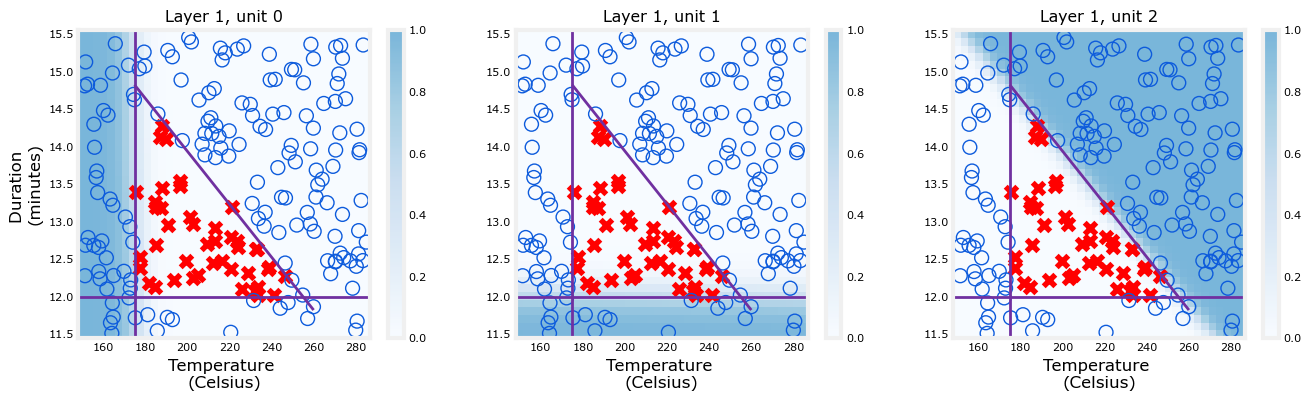

In [63]:
plt_layer(X,Y.reshape(-1,),W1,b1,norm_l)
# plt_layer: Helps visualize the internal computations or outputs of a specific neural network layer.

The shading illustrates that each unit is responsible for a different "bad roast" region. Unit 0 activates more strongly when the temperature is too low; Unit 1 activates when the duration is too short; and Unit 2 responds to unfavorable combinations of time and temperature. Notably, the network learned these functions automatically through the training process using gradient descent—demonstrating behavior that closely resembles how a human might reason through the same decision. They are very much the same sort of functions a person might choose to make the same decisions.

The output function of the final layer is a bit more challenging to visualize because its inputs are the outputs from the first layer. Since the first layer uses sigmoid activations, each of its three outputs ranges between 0 and 1. To better understand the behavior of the final layer, we can create a 3D plot showing its output across all possible combinations of these three input values.

In the plot below, high output values indicate regions corresponding to “bad roasts.” In contrast, in the bottom, the output reaches its maximum in areas where all three inputs are relatively small—corresponding to “good roast” regions.

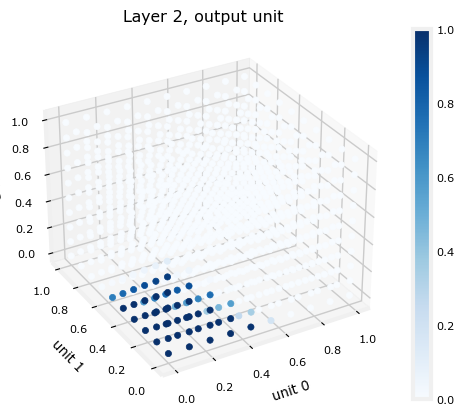

In [64]:
plt_output_unit(W2,b2)

The final visualization shows the entire network in action.
In the left graph, the blue shading represents the raw output of the final layer, overlaid with the training data—marked by X’s (positive examples) and O’s (negative examples).
In the right graph, a decision threshold has been applied to the output, converting the raw probabilities into binary predictions. The X’s and O’s now reflect the network’s classification decisions.
Note: The following cell may take a moment to run.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

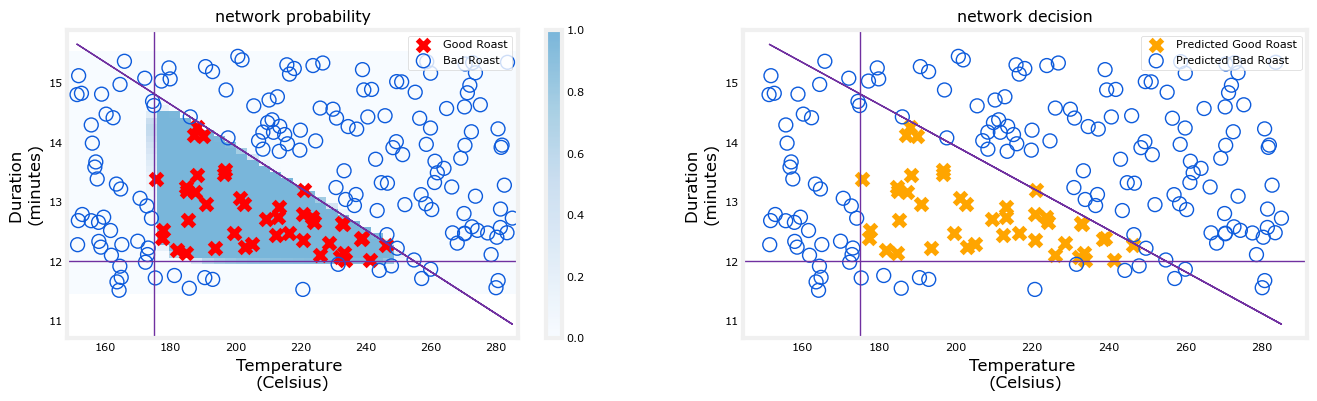

In [65]:
netf= lambda x : model.predict(norm_l(x))
plt_network(X,Y,netf)

## Congratulations!
You have built a small neural network in Tensorflow. 
The network demonstrated the ability of neural networks to handle complex decisions by dividing the decisions between multiple units.

In [66]:
np.zeros(3)

array([0., 0., 0.])

In [67]:
x = np.array([2, 3])
y = np.array([6, 5])
np.dot(x,y)

np.int64(27)